<a href="https://colab.research.google.com/github/Qu1nnD/CS290/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Allow for two centroid initialization options: either specify the initial centroids or select them randomly from the dataset being used. Experiment with both options to see how the final centroids depend on the initialization.

When applying your algorithm, plot the data and the current centroids at each iteration. This provides a nice visualization of the algorithm in action.

With both the iris and penguins datasets, you actually have labels and therefore know the correct number of clusters, 𝑘. Experiment with different values of 𝑘 to see what happens, since the “correct” value isn’t actually known in practice.

In [3]:
penguins = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/penguins.csv")
penguins.dropna(axis=0, inplace=True)

In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
 7   year               333 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 23.4+ KB


In [5]:
def ini_Centroids(k, dataset, centroid_type, features):
  if(centroid_type == "random"): # Makes the centroid random
    indices = np.random.choice(len(features), size=k, replace=False)
    return features.to_numpy()[indices]
  elif(centroid_type == 'arthur'): #arthur vestile method
    centroids = []
    first_centroid = features.sample(n=1)
    centroids.append(first_centroid.values[0])
    for x in range(1, k):
      distances = np.array([min(np.linalg.norm(x - np.array(centroid), axis=0) ** 2 for centroid in centroids) for x in features.to_numpy()])
      total_distance = distances.sum()
      probabilities = distances / total_distance  # Probability: D(x_i)^2 / sum(D(x_j)^2)
      chosen_idx = np.random.choice(len(features), p=probabilities)
      centroids.append(features.iloc[chosen_idx].values)
    return np.array(centroids)
  else: # Makes the centroid farthest away from everything
    centroids = [features[np.random.choice(features.shape[0])]]  # Choose the first centroid randomly
    for x in range(1, k):
      distances = np.array([min(np.linalg.norm(point - c) for c in centroids) for point in features])
      farthest_idx = np.argmax(distances)
      centroids.append(features[farthest_idx])
    return np.array(centroids)

In [6]:
def inertia(features, labels, centroids): #sum of the squared distances from each instance to its centroid
    total_distance = 0
    for i in range(len(centroids)):
        cluster_points = features[labels == i]
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)  # Distances to centroid
        total_distance += np.sum(distances ** 2)  # Sum of squared distances
    return total_distance

In [116]:
def sil_coe():
  plt.figure(figsize=(11,9))
  for k in (3,4,5,6):
    plt.subplot(2,2,k-2)
    y_pred=kmeans_per_k[k-1].labels
    coeffs=silhouette_coefficients[y_pred==1]
    coeffs.sort()



In [7]:
def sil_coe(data, my_kmeans):
    # Convert input data to a NumPy array (handles DataFrame or list)
    data_values = np.array(data)

    plt.figure(figsize=(11, 9))  # Set overall figure size

    for k in range(3, 7):  # Loop through cluster values 3 to 6
        plt.subplot(2, 2, k - 2)  # Create subplots for visualization

        # Step 1: Apply your custom K-Means function
        labels, centroids = my_kmeans(data_values, k)  # Replace this with your actual function

        # Step 2: Calculate silhouette coefficients
        n_samples = data_values.shape[0]
        silhouette_vals = np.zeros(n_samples)

        for i in range(n_samples):
            # Points in the same cluster
            own_cluster = data_values[labels == labels[i]]

            # Calculate 'a': Mean intra-cluster distance
            a = np.mean(np.linalg.norm(own_cluster - data_values[i], axis=1))

            # Calculate 'b': Mean distance to the nearest cluster
            b_vals = []
            for cluster_label in np.unique(labels):
                if cluster_label != labels[i]:
                    other_cluster_points = data_values[labels == cluster_label]
                    b_vals.append(np.mean(np.linalg.norm(other_cluster_points - data_values[i], axis=1)))
            b = np.min(b_vals)  # Distance to the nearest different cluster

            # Silhouette score for the sample
            silhouette_vals[i] = (b - a) / max(a, b) if max(a, b) != 0 else 0

        # Step 3: Sort silhouette values within each cluster
        silhouette_vals_sorted = []
        for cluster in np.unique(labels):
            silhouette_vals_sorted.append(np.sort(silhouette_vals[labels == cluster]))

        # Step 4: Plot flowy silhouette coefficients
        y_lower = 0
        for i, cluster_sil_vals in enumerate(silhouette_vals_sorted):
            cluster_size = cluster_sil_vals.shape[0]
            y_upper = y_lower + cluster_size

            plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_vals, alpha=0.7)

            y_lower = y_upper + 10  # Gap between clusters

        avg_silhouette = np.mean(silhouette_vals)
        plt.axvline(x=avg_silhouette, color='red', linestyle='--')  # Average silhouette score line

        plt.title(f'Silhouette Plot for k={k}')
        plt.xlabel('Silhouette Coefficient')
        plt.ylabel('Samples')

    plt.tight_layout()  # Adjust subplots for better layout
    plt.show()

In [8]:
def accuracy(true_labels, predicted_labels):
    correct_predictions = np.sum(true_labels == predicted_labels)
    return correct_predictions / len(true_labels)

In [9]:
def K_Means(k, dataset, centroid_type, feature_x, feature_y):
    converged = False
    features = dataset[[feature_x, feature_y]].dropna()
    centroids=ini_Centroids(k, dataset, centroid_type, features) # initializes the first centroids
    while not converged: # Loops until there isn't massive changes between centroids and new_centroids
        #Calculations
        distances = np.linalg.norm(features.to_numpy()[:, np.newaxis] - centroids, axis=2) # calcuates the eudclidean distance between data points and centroids
        labels = np.argmin(distances, axis=1) # assigns data points to the closest centroid
        new_centroids = np.array([features[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)]) # calculates updated centroids given the mean of all data points from each cluster
        #Ploting

        plt.figure()
        plt.scatter(features[feature_x], features[feature_y], c=labels, marker='o') # Creates the circles that represent data points on the scatter plot
        for c in centroids:
          plt.scatter(c[0], c[1], c='red',marker='X', s=200) # Creates the red X markers that show where the centroids are on the scatter plot
        plt.title(f'Current Centroids for k={k}') # Creates the title of the scatter plot
        plt.xlabel(feature_x) # Creates the x axis label for the scatter plot
        plt.ylabel(feature_y) # Creates the y axis label for the scatter plot
        plt.show() # Prints the scatter plot

        #Convergence test and updating centroids
        #fix later
        converged = np.all(np.abs(centroids - new_centroids) <= 0.01) # Tests to see if there is major differences between the current and new centroids to see if it needs to continue the loop again
        centroids = new_centroids
    return labels, centroids

Running K-Means with k=3


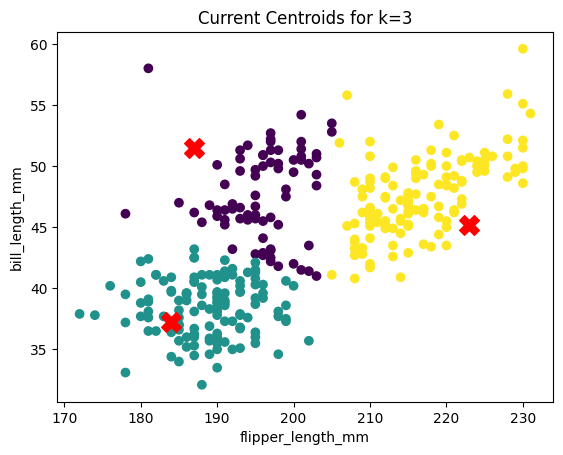

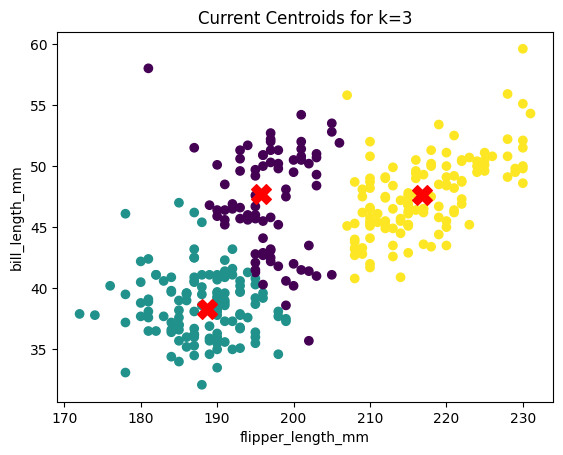

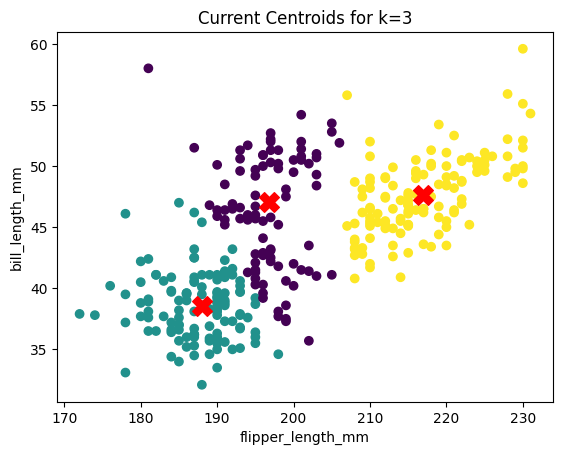

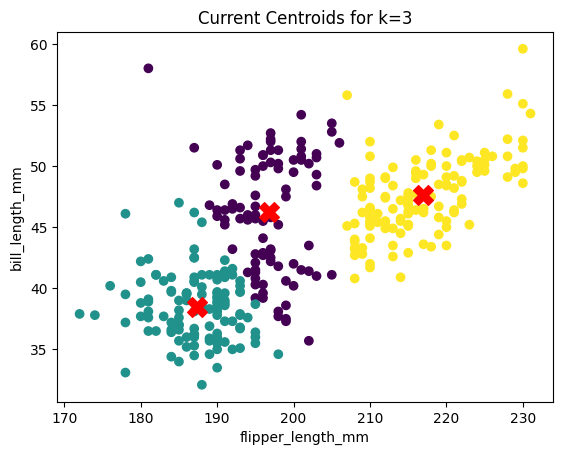

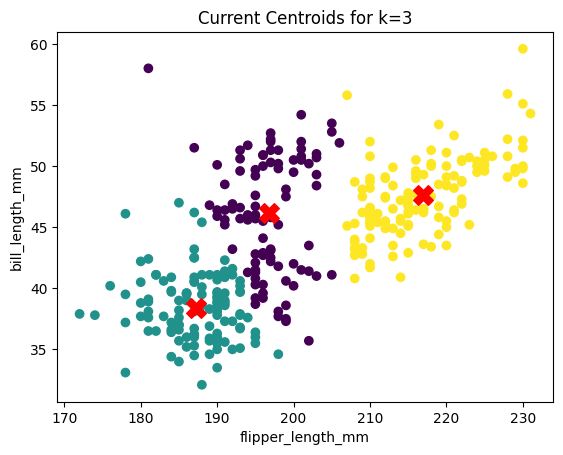

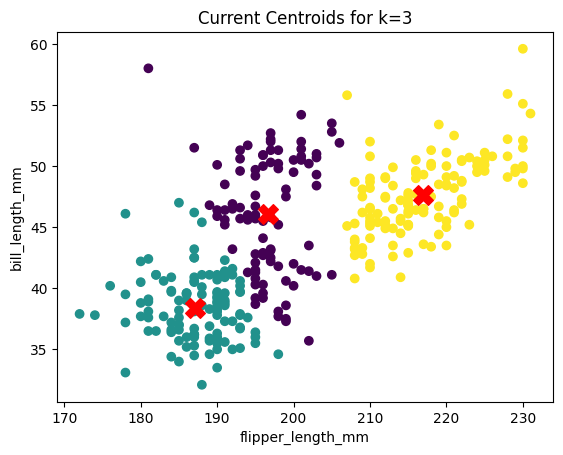

Accuracy: 0.13


In [11]:
for k in range(3,4):
  print(f"Running K-Means with k={k}")
  labels, clusters = K_Means(k, penguins, "random",'flipper_length_mm','bill_length_mm',)
  true_labels = penguins['species']
  species_names = penguins['species'].unique()
  predicted_species = species_names[labels] # maps numerical labels to string labels using NumPy indexing
  a = accuracy(true_labels, predicted_species)
  print(f'Accuracy: {a:.2f}')

Running K-Means with k=3


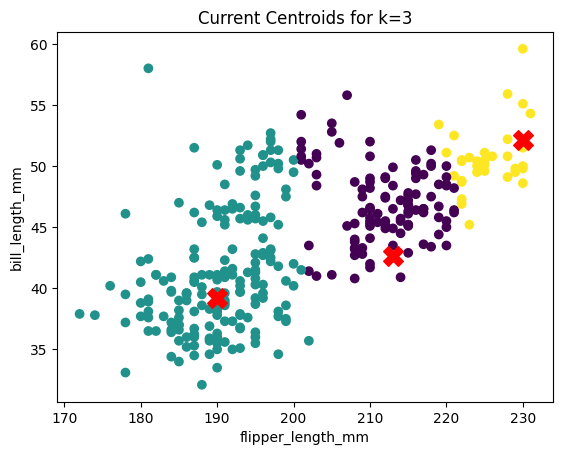

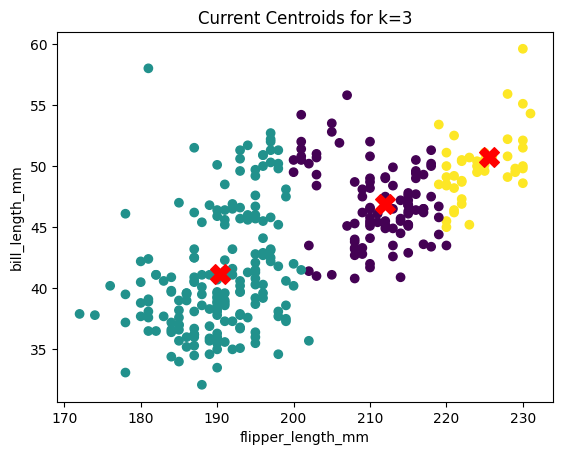

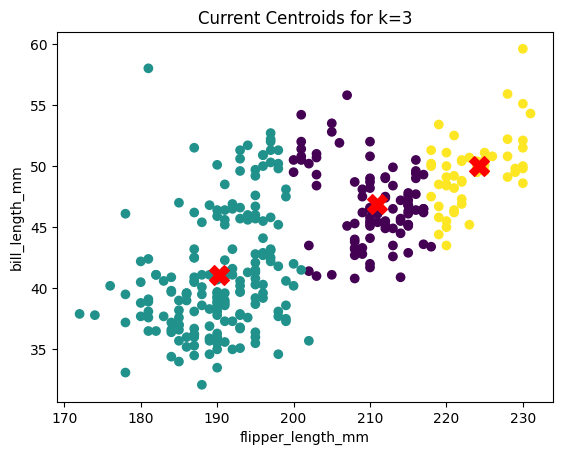

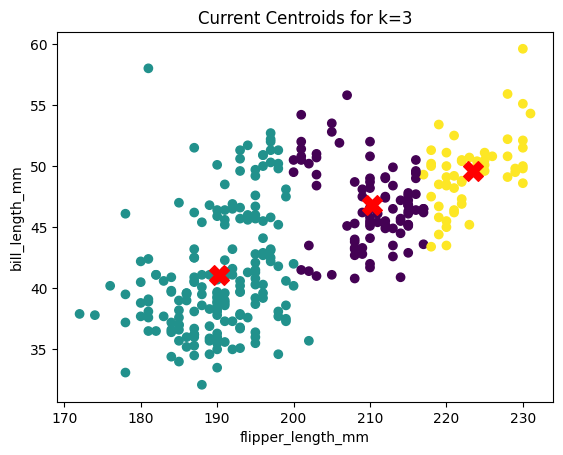

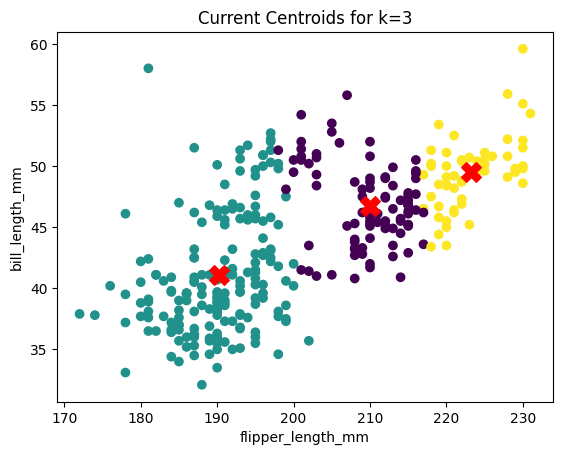

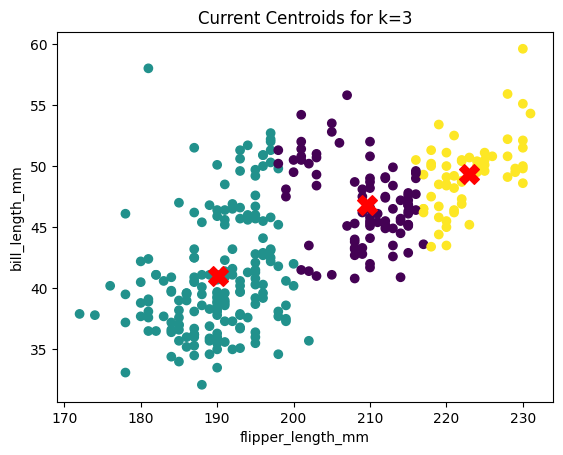

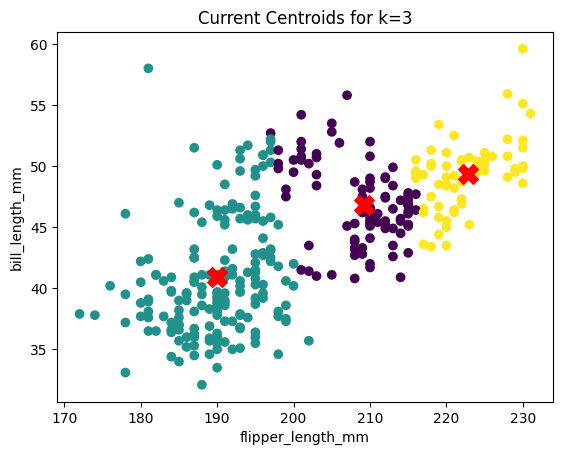

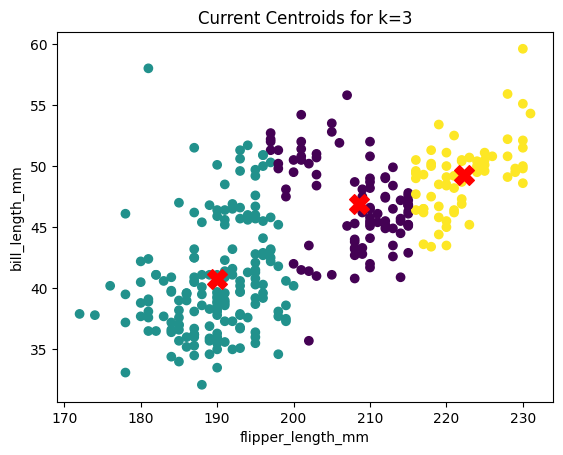

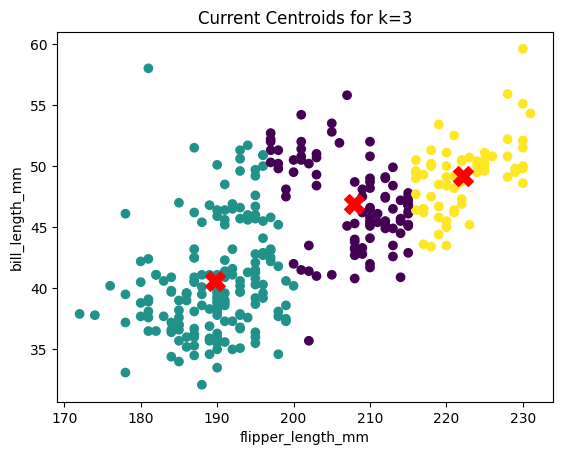

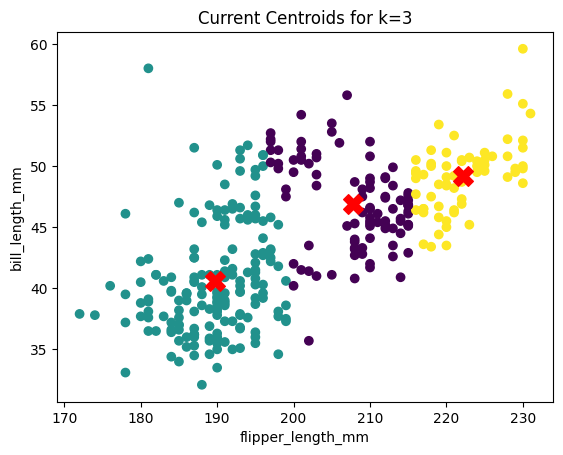

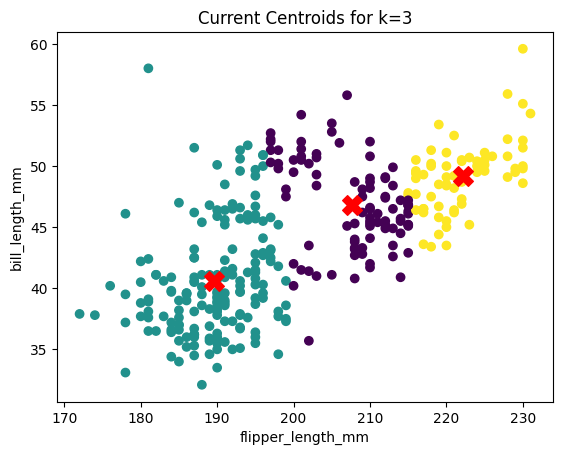

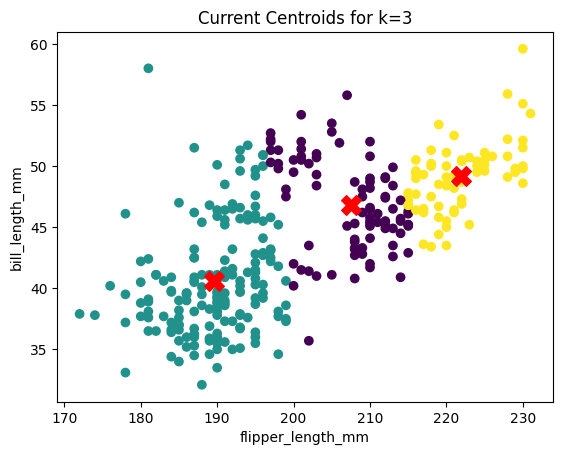

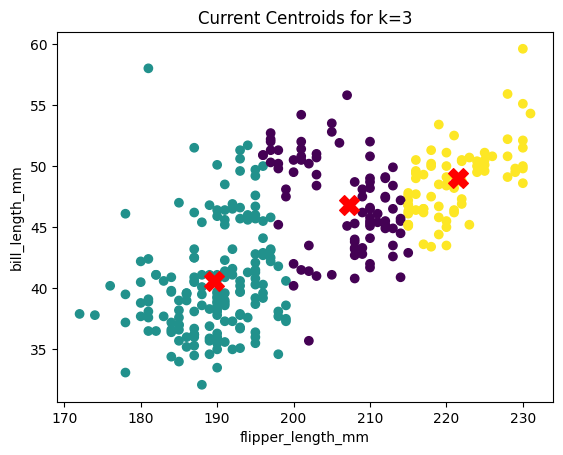

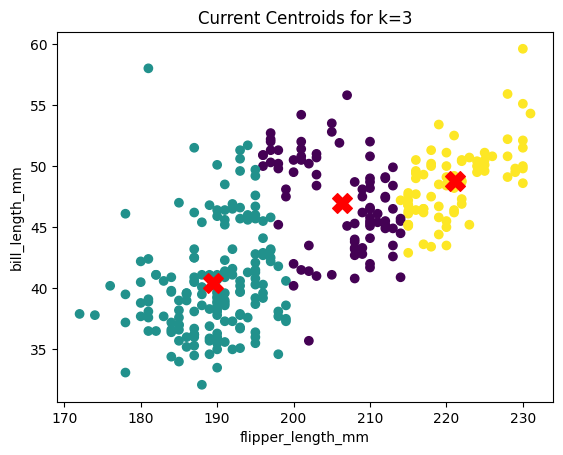

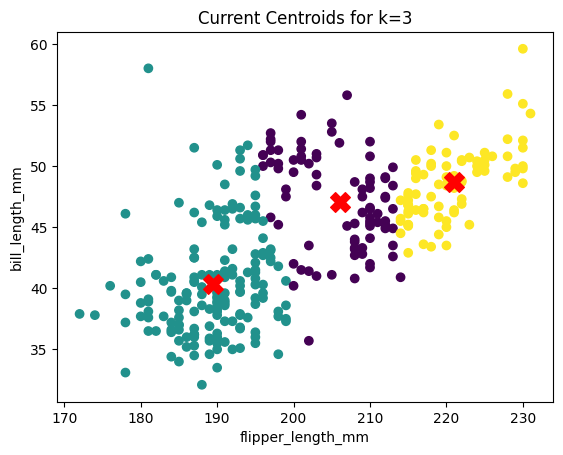

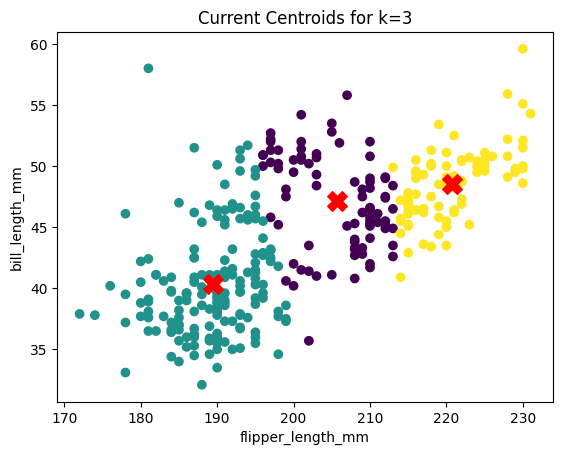

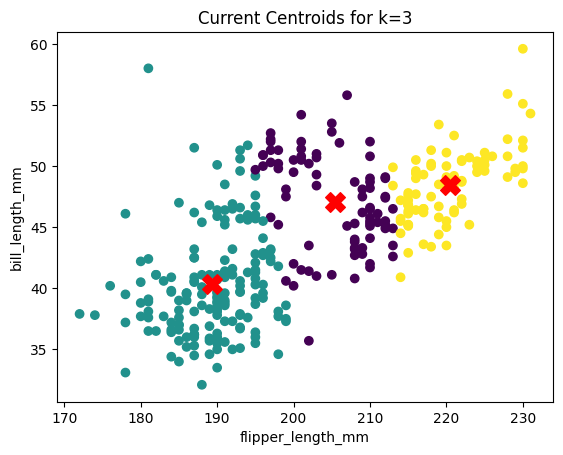

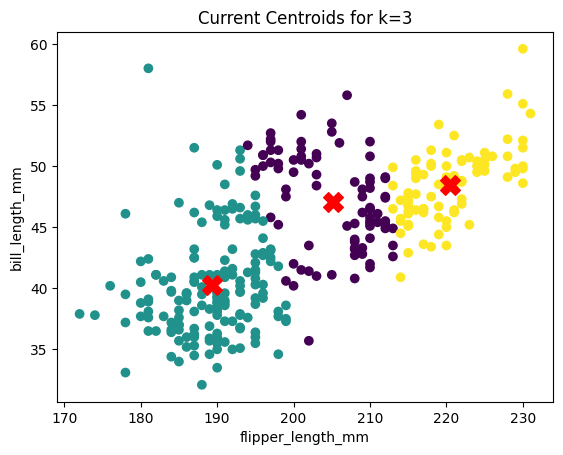

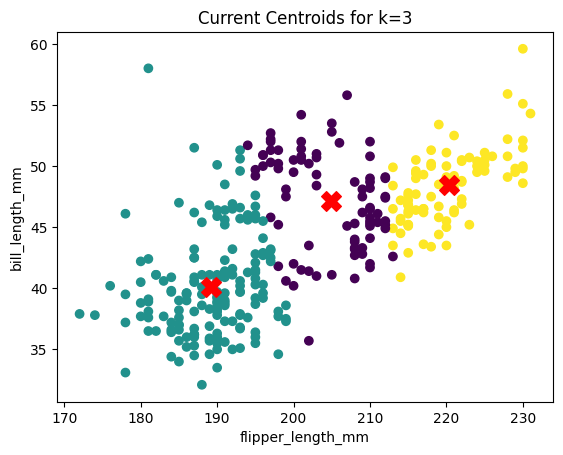

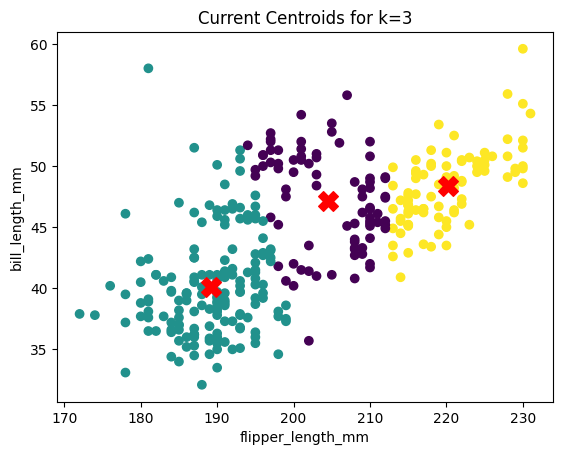

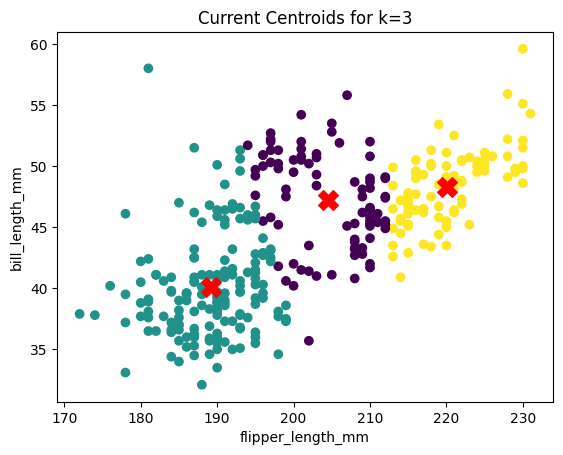

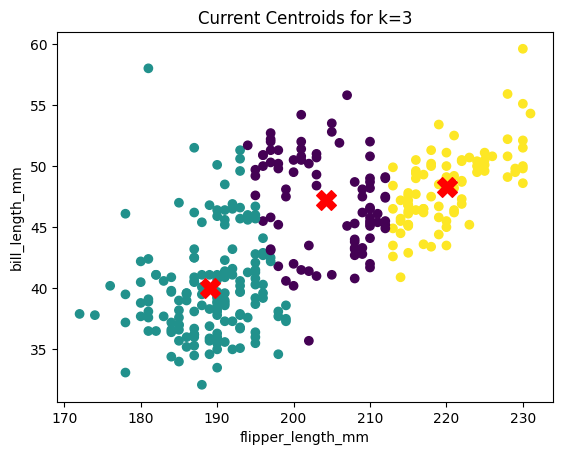

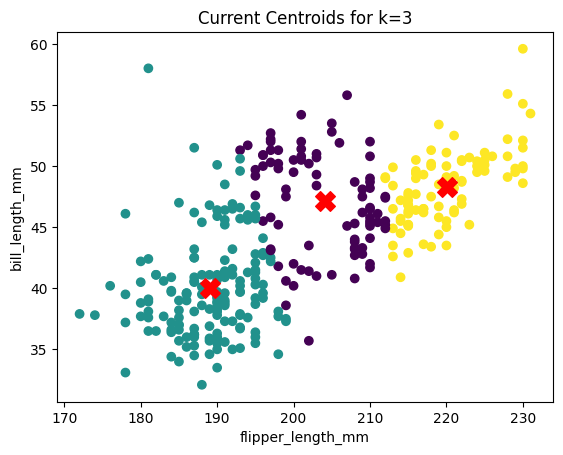

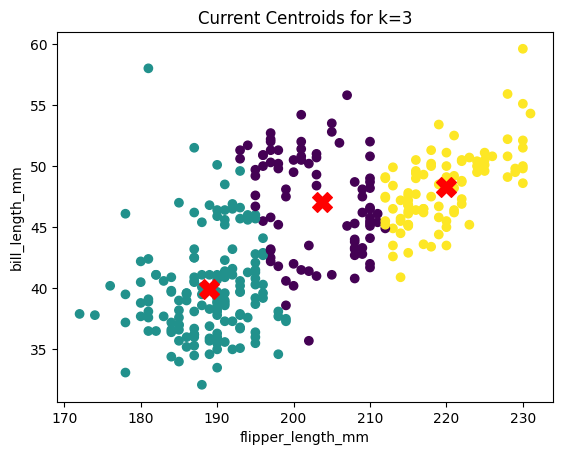

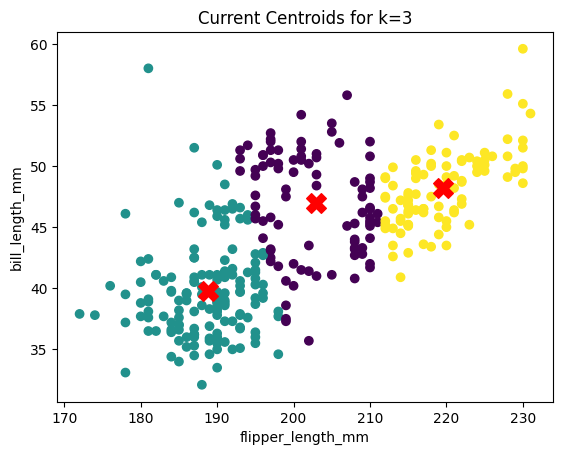

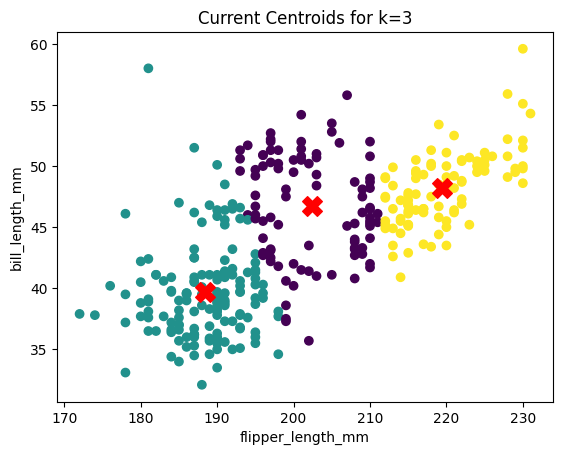

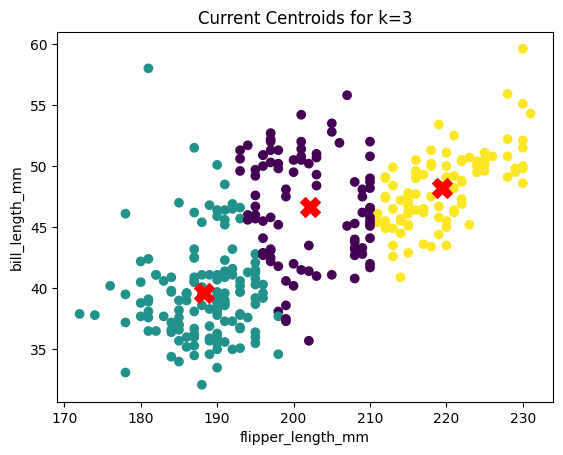

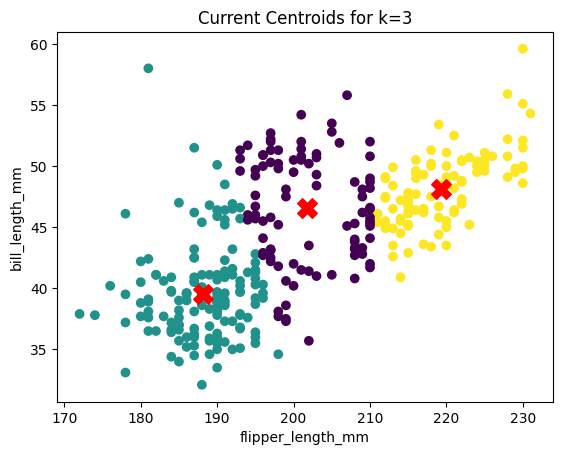

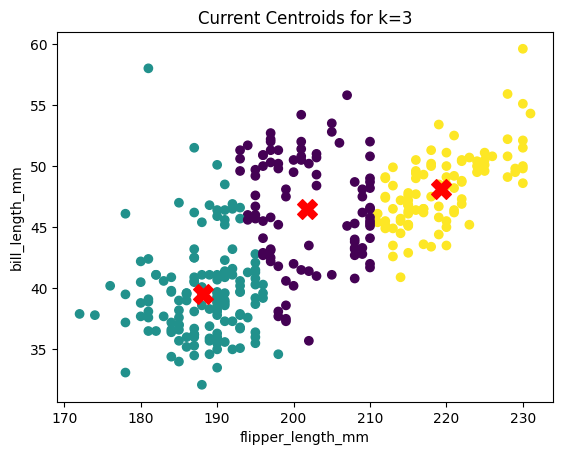

Accuracy: 0.00


In [12]:
for k in range(3,4):
  print(f"Running K-Means with k={k}")
  labelsA, clusters = K_Means(k, penguins, "arthur", 'flipper_length_mm', 'bill_length_mm')
acc = accuracy(true_labels, labelsA)
print(f'Accuracy: {acc:.2f}')

In [137]:
for k in range(3,4):
  print(f"Running K-Means with k={k}")
  labelsF, clusters = K_Means(k, penguins, "other", 'flipper_length_mm', 'bill_length_mm')
accuracy = accuracy(true_labels, labelsF)
print(f'Accuracy: {accuracy:.2f}')

Running K-Means with k=3


KeyError: 58

In [17]:
mystery = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/mystery.csv")

In [18]:
def K_Means2(k, dataset, centroid_type, feature_x, feature_y):
    converged = False
    features = dataset[[feature_x, feature_y]].dropna()
    indices = np.random.choice(len(features), size=k, replace=False)
    centroids=features.to_numpy()[indices]
    while not converged:
      distances = np.linalg.norm(features.to_numpy()[:, np.newaxis] - centroids, axis=2)
      labels = np.argmin(distances, axis=1) # assigns data points to the closest centroid
      new_centroids = np.array([features[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)]) # calculates updated centroids given the mean of all data points from each cluster
        #Ploting

      plt.figure()
      plt.scatter(features['flipper_length_mm'], features['bill_length_mm'], c=labels, marker='o') # Creates the circles that represent data points on the scatter plot
      plt.title(f'Current Centroids for k={k}') # Creates the title of the scatter plot
      plt.xlabel('flipper_length_mm') # Creates the x axis label for the scatter plot
      plt.ylabel('bill_length_mm') # Creates the y axis label for the scatter plot
      for c in centroids:
        plt.scatter(c[0], c[1], c='red',marker='X', s=200) # Creates the red X markers that show where the centroids are on the scatter plot
      plt.show()

        #Convergence test and updating centroids
        #fix later
    converged = np.all(np.abs(centroids - new_centroids) <= 0.01) # Tests to see if there is major differences between the current and new centroids to see if it needs to continue the loop again
    centroids = new_centroids
    return labels, centroids

In [326]:
#K_Means(3, penguins, "random", 'flipper_length_mm', 'bill_length_mm')

In [342]:
features=penguins[['flipper_length_mm', 'bill_length_mm']]
#filtered_features = features[(features['bill_length_mm'] > 42)]

In [343]:
indices = np.random.choice(len(features), size=k, replace=False)
indices

array([238, 174, 125])

In [344]:
centroids=features.to_numpy()[indices]
centroids

array([[214. ,  44.5],
       [220. ,  50. ],
       [197. ,  43.1]])

In [345]:
stuff=features.to_numpy()
stuff[14]

array([194.,  46.])

In [346]:
distances = np.linalg.norm(features.to_numpy()[:, np.newaxis] - centroids, axis=2)
distances[14]

array([20.05617112, 26.30589288,  4.17252921])

In [347]:
labels = np.argmin(distances, axis=1)
labels[14]

2

In [348]:
new_centroids = np.array([features[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)])
new_centroids

array([[211.91780822,  46.1890411 ],
       [222.92727273,  49.82      ],
       [191.17560976,  41.64731707]])

In [19]:
plt.figure()
plt.scatter(features['flipper_length_mm'], features['bill_length_mm'], c=labels, marker='o') # Creates the circles that represent data points on the scatter plot
plt.title(f'Current Centroids for k={k}') # Creates the title of the scatter plot
plt.xlabel('flipper_length_mm') # Creates the x axis label for the scatter plot
plt.ylabel('bill_length_mm') # Creates the y axis label for the scatter plot
for c in centroids:
  plt.scatter(c[0], c[1], c='red',marker='X', s=200) # Creates the red X markers that show where the centroids are on the scatter plot
plt.show()

NameError: name 'features' is not defined

<Figure size 640x480 with 0 Axes>

In [350]:
converged = np.all(np.abs(centroids - new_centroids) <= 0.01)
converged

False

In [351]:
centroids = new_centroids
centroids

array([[211.91780822,  46.1890411 ],
       [222.92727273,  49.82      ],
       [191.17560976,  41.64731707]])

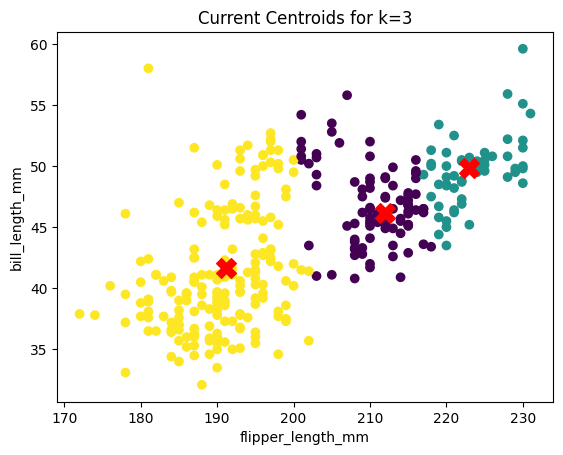

In [352]:
plt.figure()
distances = np.linalg.norm(features.to_numpy()[:, np.newaxis] - centroids, axis=2)
labels = np.argmin(distances, axis=1)
plt.scatter(features['flipper_length_mm'], features['bill_length_mm'], c=labels, marker='o') # Creates the circles that represent data points on the scatter plot
plt.title(f'Current Centroids for k={k}') # Creates the title of the scatter plot
plt.xlabel('flipper_length_mm') # Creates the x axis label for the scatter plot
plt.ylabel('bill_length_mm') # Creates the y axis label for the scatter plot
for c in centroids:
  plt.scatter(c[0], c[1], c='red',marker='X', s=200) # Creates the red X markers that show where the centroids are on the scatter plot
plt.show()